# Notebook per la conversione del datasample Indici_RDcentri

In questo notebook facciamo uso delle librerie python 

pandas & astropy

per leggere una tabella in formato csv, importarla come un dataframe e salvarlo in csv, trasformare il dataframe in una Qtable di astropy e trasformare la Qtable in VOTable, salvare la VOTable in formato xml.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from astropy.table import QTable
import astropy.units as u

from astropy.io import votable 
from astropy.io.votable import from_table, writeto, parse

from astropy.coordinates import SkyCoord
import sunpy.coordinates


Dopo aver importato tutte le librerie necessarie, leggiamo il file txt e creiamo la colonna standard del tempo.

In [19]:
directory='./'
file1='indici_RDcentri.csv'

df1 = pd.read_csv(directory+file1, header=None)    #lettura del file. Indica esplicitamente che l'header è alla row 0
df1.rename(columns={0: "HARP_number", 1: "datetime", 2: "R_UTOV", 3: "D", 4: "X_pos", 5: "Y_pos", 6: "R_Sun"}, inplace=True)


datestring=[]
i=0
for datet in df1["datetime"]: 
    datestring.append(datet[1:20])
    #print(datestring[i])
    i+=1

#datestring=df1['LASCO_Date']
df1.insert(0, 'Time', datestring) # inserire la colonna Time come prima colonna

#df1.to_csv(directory+file_out, index=False)

df1

Time  HARP_number                    datetime  R_UTOV  \
0      2012-09-14T03:00:03          476   2012-09-14T03:00:03+00:00  3.3818   
1      2012-09-14T09:00:03          476   2012-09-14T09:00:03+00:00  3.5464   
2      2012-09-14T15:00:03          476   2012-09-14T15:00:03+00:00  3.4330   
3      2012-09-14T18:00:03          476   2012-09-14T18:00:03+00:00  3.4068   
4      2012-09-14T21:00:03          476   2012-09-14T21:00:03+00:00  3.5157   
...                    ...          ...                         ...     ...   
35994  2016-04-12T12:00:01         4996   2016-04-12T12:00:01+00:00  3.1618   
35995  2016-04-12T15:00:01         4996   2016-04-12T15:00:01+00:00  3.0275   
35996  2016-04-12T18:00:01         4996   2016-04-12T18:00:01+00:00  2.6275   
35997  2016-04-12T21:00:01         4996   2016-04-12T21:00:01+00:00  0.6896   
35998  2016-04-13T00:00:01         4996   2016-04-13T00:00:01+00:00  2.6462   

       D      X_pos     Y_pos      R_Sun  
0      1  1612.9648  720.9119  1891.4001  
1      1  1659.0387  731.7861  1891.2666  
2      1  1700.8168  743.6094  1892.1681  
3      1  1718.9973  757.7131  1892.5017  
4      1  1736.0341  764.7866  1892.5091  
...   ..        ...       ...        ...  
35994  0   710.5037  752.4746  1897.6101  
35995  0   761.5635  752.4771  1897.8841  
35996  0   812.5101  752.3945  1897.9984  
35997  0   861.5554  751.4263  1897.8456  
35998  0   909.4899  749.3489  1897.4675  

[35999 rows x 8 columns]

 Adesso inseriamo le colonne STANDARD per le coordinate
 
 in questo caso: 
 
 Helioprojective Cartesian (HPC)
 
 The origin is the location of the observer.

Tx (aka “theta_x”) is the angle relative to the plane containing the Sun-observer line and the Sun’s rotation axis, with positive values in the direction of the Sun’s west limb.

Ty (aka “theta_y”) is the angle relative to the Sun’s equatorial plane, with positive values in the direction of the Sun’s north pole.

distance is the Sun-observer distance.

This system is frequently used in a projective form without distance specified. For observations looking very close to the center of the Sun, where the small-angle approximation is appropriate, Tx and Ty can be approximated as Cartesian components.




In [3]:
Tx_vec=[]
Ty_vec=[]
SUN_dist=[]
AU1=u.astrophys.AU
rsun= 695700.0* u.km

i=0
for date, x,y, R_sun in zip(df1['Time'],df1['X_pos'],df1['Y_pos'],df1['R_Sun']): 
    dist=sunpy.coordinates.sun.earth_distance(time=date)
    dist_in_km=dist*AU1.in_units(u.km)
    Tsun= 695700.0/dist_in_km.value
    Tx=(x/R_sun)*Tsun*u.rad
    Ty=(y/R_sun)*Tsun*u.rad
    sc1 = SkyCoord(Tx, Ty, 0*u.km, obstime=date, observer="earth", frame="helioprojective")
    Tx_vec.append(sc1.Tx.value)
    Ty_vec.append(sc1.Ty.value)
    SUN_dist.append(dist.value)
    if (i%1000)==0:
        print(i)
    i+=1



0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000


In [20]:
df1.insert(1, 'HPC_Tx', Tx_vec) # inserire la colonna Tx come seconda colonna
df1.insert(2, 'HPC_Ty', Ty_vec) # inserire la colonna Ty come terza colonna
df1.insert(3, 'HPC_distance', SUN_dist) # inserire la colonna Tz come quarta colonna

Adesso creiamo le righe con la tipologia di dataentry e le units per ogni colonna.
Piccolo trucco per inserirle alla fine, e poi shiftare l'indice per avere gli header nelle prime tre righe 

In [21]:
head1=df1.columns 
head_quantity=df1.loc[0]
head_quantity[0]="UTC" 
head_quantity[1]="arcsec" 
head_quantity[2]="arcsec" 
head_quantity[3]="AU" 
head_quantity[4]="index" 
head_quantity[5]="UTC" 
head_quantity[6]="" 
head_quantity[7]="" 
head_quantity[8]="pixel"  
head_quantity[9]="pixel"
head_quantity[10]="pixel"

head_type=["datetime","float","float","float","int","datetime","float","int","float","float","float"]
null_type=["-",np.nan,np.nan,np.nan,"-9999","-",np.nan,-1,np.nan,np.nan,np.nan]

df1.loc[-1] = head_quantity  # adding the headers at the end 
df1.loc[-2] = null_type  # adding 
df1.loc[-3] = head_type  # adding 

  
df1.drop([0],inplace=True)
df1.index=df1.index +3
df = df1.sort_index()
df

/tmp/ipykernel_386956/3997444382.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  head_quantity[0]="UTC"
/tmp/ipykernel_386956/3997444382.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  head_quantity[1]="arcsec"
/tmp/ipykernel_386956/3997444382.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  head_quantity[2]="arcsec"
/tmp/ipykernel_386956/3997444382.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

Time      HPC_Tx      HPC_Ty HPC_distance HARP_number  \
0                 datetime       float       float        float         int   
1                        -         NaN         NaN          NaN       -9999   
2                      UTC      arcsec      arcsec           AU       index   
4      2012-09-14T09:00:03   836.57539  369.005402      1.00582         476   
5      2012-09-14T15:00:03  857.290261  374.813499     1.005754         476   
...                    ...         ...         ...          ...         ...   
35997  2016-04-12T12:00:01  358.222284  379.383204     1.002602        4996   
35998  2016-04-12T15:00:01  383.896948   379.31658     1.002636        4996   
35999  2016-04-12T18:00:01  409.539833     379.239     1.002671        4996   
36000  2016-04-12T21:00:01  434.280731  378.768403     1.002706        4996   
36001  2016-04-13T00:00:01   458.51841  377.783488      1.00274        4996   

                         datetime  R_UTOV    D      X_pos     Y_pos      R_Sun  
0                        datetime   float  int      float     float      float  
1                               -     NaN   -1        NaN       NaN        NaN  
2                             UTC                   pixel     pixel      pixel  
4       2012-09-14T09:00:03+00:00  3.5464    1  1659.0387  731.7861  1891.2666  
5       2012-09-14T15:00:03+00:00   3.433    1  1700.8168  743.6094  1892.1681  
...                           ...     ...  ...        ...       ...        ...  
35997   2016-04-12T12:00:01+00:00  3.1618    0   710.5037  752.4746  1897.6101  
35998   2016-04-12T15:00:01+00:00  3.0275    0   761.5635  752.4771  1897.8841  
35999   2016-04-12T18:00:01+00:00  2.6275    0   812.5101  752.3945  1897.9984  
36000   2016-04-12T21:00:01+00:00  0.6896    0   861.5554  751.4263  1897.8456  
36001   2016-04-13T00:00:01+00:00  2.6462    0   909.4899  749.3489  1897.4675  

[36001 rows x 11 columns]

Definizione nome output e
Scrittura del file in formato csv

In [22]:
file_out='indici_RDcentri_edit.csv'
df.to_csv(directory+file_out, index=False)

Per verificare che la scrittura sia andata a buon fine, re-importiamo il dataframe

In [25]:
df_check = pd.read_csv(directory+file_out)
df_check

Time              HPC_Tx              HPC_Ty  \
0                 datetime               float               float   
1                        -                 NaN                 NaN   
2                      UTC              arcsec              arcsec   
3      2012-09-14T09:00:03   836.5753903659471   369.0054019064619   
4      2012-09-14T15:00:03   857.2902606566743  374.81349922740253   
...                    ...                 ...                 ...   
35996  2016-04-12T12:00:01  358.22228448327803  379.38320409540563   
35997  2016-04-12T15:00:01  383.89694807797554  379.31657988935336   
35998  2016-04-12T18:00:01   409.5398329691563    379.239000052937   
35999  2016-04-12T21:00:01   434.2807308625491   378.7684027670665   
36000  2016-04-13T00:00:01   458.5184103460581  377.78348766992053   

             HPC_distance HARP_number                    datetime  R_UTOV  \
0                   float         int                    datetime   float   
1                     NaN       -9999                           -     NaN   
2                      AU       index                         UTC     NaN   
3      1.0058203164563235         476   2012-09-14T09:00:03+00:00  3.5464   
4      1.0057537374714662         476   2012-09-14T15:00:03+00:00   3.433   
...                   ...         ...                         ...     ...   
35996  1.0026018138663775        4996   2016-04-12T12:00:01+00:00  3.1618   
35997   1.002636472368843        4996   2016-04-12T15:00:01+00:00  3.0275   
35998   1.002671110305877        4996   2016-04-12T18:00:01+00:00  2.6275   
35999  1.0027057281535194        4996   2016-04-12T21:00:01+00:00  0.6896   
36000  1.0027403263846715        4996   2016-04-13T00:00:01+00:00  2.6462   

         D      X_pos     Y_pos      R_Sun  
0      int      float     float      float  
1       -1        NaN       NaN        NaN  
2      NaN      pixel     pixel      pixel  
3        1  1659.0387  731.7861  1891.2666  
4        1  1700.8168  743.6094  1892.1681  
...    ...        ...       ...        ...  
35996    0   710.5037  752.4746  1897.6101  
35997    0   761.5635  752.4771  1897.8841  
35998    0   812.5101  752.3945  1897.9984  
35999    0   861.5554  751.4263  1897.8456  
36000    0   909.4899  749.3489  1897.4675  

[36001 rows x 11 columns]

Prepariamo i dati per l'inserimento in una Qtable di astropy.

Forziamo il type sulle colonne (adesso sono tutte delle stringhe)


In [27]:
df_new=df_check.drop([0,2])
df_new['HARP_number'] = df_new['HARP_number'].astype(int)
df_new['R_UTOV'] = df_new['R_UTOV'].astype(float)
df_new['D'] = df_new['D'].astype(int)
df_new['X_pos'] = df_new['X_pos'].astype(float)
df_new['Y_pos'] = df_new['Y_pos'].astype(float)
df_new['R_Sun'] = df_new['R_Sun'].astype(float)
df_new['HPC_Tx'] = df_new['HPC_Tx'].astype(float)
df_new['HPC_Ty'] = df_new['HPC_Ty'].astype(float)
df_new['HPC_distance'] = df_new['HPC_distance'].astype(float)

#ype(df_new['Analyitic_gamma'])


Inseriamo i dati in una Qtable di astropy.

E dopo possiamo associare le units alle colonne che lo necessitano

In [40]:
# https://docs.astropy.org/en/stable/table/pandas.html
ATable= QTable.from_pandas(df_new)

ATable['X_pos'] = ATable['X_pos']*u.pixel
ATable['Y_pos'] = ATable['Y_pos']*u.pixel
ATable['R_Sun'] = ATable['R_Sun']*u.pixel
ATable['HPC_Tx'] = ATable['HPC_Tx']*u.arcsec
ATable['HPC_Ty'] = ATable['HPC_Ty']*u.arcsec
ATable['HPC_distance'] = ATable['HPC_distance']*u.astrophys.AU


ATable

<QTable length=35999>
        Time              HPC_Tx             HPC_Ty          HPC_distance    HARP_number ...  R_UTOV   D     X_pos    Y_pos     R_Sun  
                          arcsec             arcsec               AU                     ...                  pix      pix       pix   
       str19             float64            float64            float64          int64    ... float64 int64  float64  float64   float64 
------------------- ------------------ ------------------ ------------------ ----------- ... ------- ----- --------- -------- ---------
                  -                nan                nan                nan       -9999 ...      --    -1       nan      nan       nan
2012-09-14T09:00:03  836.5753903659471  369.0054019064619 1.0058203164563235         476 ...  3.5464     1 1659.0387 731.7861 1891.2666
2012-09-14T15:00:03  857.2902606566743 374.81349922740253 1.0057537374714662         476 ...   3.433     1 1700.8168 743.6094 1892.1681
2012-09-14T18:00:03   866.330076500745   381.867759704228 1.0057203749686006         476 ...  3.4068     1 1718.9973 757.7131 1892.5017
2012-09-14T21:00:03  874.9418277076487  385.4439181870439 1.0056869636139594         476 ...  3.5157     1 1736.0341 764.7866 1892.5091
2012-09-15T00:00:03  882.6496332526114   388.072900998779  1.005653503293598         476 ...  3.5195     1 1751.0194 769.8674 1892.2389
                ...                ...                ...                ...         ... ...     ...   ...       ...      ...       ...
2016-04-12T00:00:01  242.7352807495882  382.2908908356005 1.0024629646036556        4996 ...  1.4445     1  481.4756   758.29 1897.9937
2016-04-12T06:00:01  298.2405907696865 380.93372578442273  1.002532433248656        4996 ...  2.2315     0  591.4115 755.3921  1897.345
2016-04-12T12:00:01 358.22228448327803 379.38320409540563 1.0026018138663775        4996 ...  3.1618     0  710.5037 752.4746 1897.6101
2016-04-12T15:00:01 383.89694807797554 379.31657988935336  1.002636472368843        4996 ...  3.0275     0  761.5635 752.4771 1897.8841
2016-04-12T18:00:01  409.5398329691563   379.239000052937  1.002671110305877        4996 ...  2.6275     0  812.5101 752.3945 1897.9984
2016-04-12T21:00:01  434.2807308625491  378.7684027670665 1.0027057281535194        4996 ...  0.6896     0  861.5554 751.4263 1897.8456
2016-04-13T00:00:01  458.5184103460581 377.78348766992053 1.0027403263846715        4996 ...  2.6462     0  909.4899 749.3489 1897.4675

Trasformiamo la astropy Qtable in una VOTable e la scriviamo su file

In [29]:
#https://docs.astropy.org/en/stable/io/votable/index.html
votable = from_table(ATable)
file_out2='indici_RDcentri_edit.xml'
writeto(votable, file_out2)


Per verificare che la scrittura sia andata a buon fine, re-importiamo la VOTable

<Figure size 360x360 with 0 Axes>

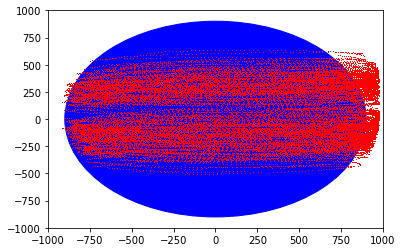

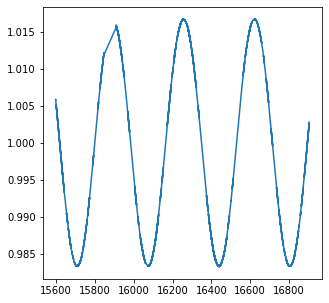

In [58]:
import astropy 

votable = parse(file_out2)
intable = votable.get_first_table()
x=intable.array["HPC_Tx"]
y=intable.array["HPC_Ty"]

circle=plt.Circle((0, 0), 900, color='blue')
plt.figure(figsize=(5,5))
fig, ax = plt.subplots()

ax.add_patch(circle)
plt.plot(x,y,',r')
plt.xlim(-1000,1000)
plt.ylim(-1000,1000)
plt.show()

times=intable.array["Time"]
t = astropy.time.Time(times[1:], format='isot', scale='utc')
D=intable.array["HPC_distance"]
D=D[1:]

plt.figure(figsize=(5,5))
plt.plot(t.plot_date,D)
plt.show()

In [57]:
D[0]

masked